# Base Model: Feature Extraction & Linear Probing

This notebook demonstrates how to use Panda's base encoder to extract point-wise features from LArTPC point clouds. 

**Contents:**
1. Load model and extract features
2. Visualize features with PCA
3. Linear probing for semantic segmentation

## 1. Load Model & Data


In [1]:
import torch
import panda

model = panda.load("base").cuda()

# auto-download from HuggingFace (or use local data_root if available)
dataset = panda.PILArNetH5Dataset(split="val", energy_threshold=0.13)

data = dataset[0]
for k in data.keys():
    data[k] = data[k].cuda(non_blocking=True)

with torch.no_grad(), torch.inference_mode():
    output = model(data)

## 2. PCA Visualization

Project the high-dimensional features (512-d) to 3 principal components and use them as RGB colors. Points with similar features will have similar colors, revealing the model's learned structure.

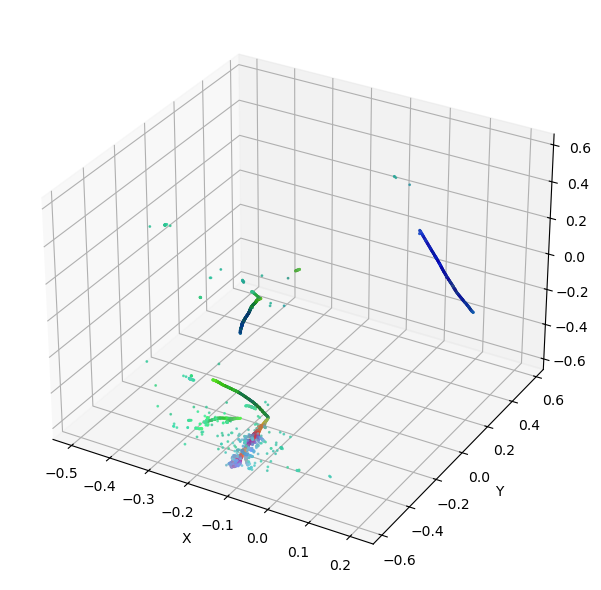

In [2]:
import matplotlib.pyplot as plt

pca, _, _ = torch.pca_lowrank(output.feat, q=3, niter=3, center=True)
colors = (pca - pca.amin(dim=0)) / (pca.amax(dim=0) - pca.amin(dim=0))
colors = colors.cpu().numpy()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

coords = data['coord'].cpu().numpy()
sc = ax.scatter(
    coords[:, 0],
    coords[:, 1],
    coords[:, 2],
    c=colors,
    s=1,
    alpha=0.8
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.show()


## 3. Linear Probing

Linear probing evaluates feature quality by training a simple linear classifier on frozen backbone features. Good representations should be linearly separable for downstream tasks.

Here we train a linear head for **semantic segmentation** (classifying points as Shower, Track, Michel, Delta, or LED).

In [3]:
from tqdm import tqdm
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=panda.utils.collate_fn)

train_events = {'coord':[], 'feat':[], 'label':[]}
val_events = {'coord':[], 'feat':[], 'label':[]}

for i, data in enumerate(tqdm(dataloader, total=2000 // 50)):
    for k in data.keys():
        data[k] = data[k].cuda(non_blocking=True)
    with torch.no_grad(), torch.inference_mode():
        output = model(data)

    if i < 1000 // 50:
        train_events['coord'].append(data['coord'].cpu())
        train_events['feat'].append(output.feat.cpu())
        train_events['label'].append(data['segment_motif'].cpu())
    elif i < 2000 // 50:
        val_events['coord'].append(data['coord'].cpu())
        val_events['feat'].append(output.feat.cpu())
        val_events['label'].append(data['segment_motif'].cpu())
    else:
        break

train_events['coord'] = torch.cat(train_events['coord'], dim=0)
train_events['feat'] = torch.cat(train_events['feat'], dim=0)
train_events['label'] = torch.cat(train_events['label'], dim=0)

val_events['coord'] = torch.cat(val_events['coord'], dim=0)
val_events['feat'] = torch.cat(val_events['feat'], dim=0)
val_events['label'] = torch.cat(val_events['label'], dim=0)

100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


In [4]:
print("Num points in train set:", train_events['coord'].shape[0])
print("Num points in val set:", val_events['coord'].shape[0])

Num points in train set: 3425055
Num points in val set: 3323045


In [5]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

# training and validation data
X_train = train_events['feat']
y_train = train_events['label'].long().view(-1)
X_val = val_events['feat']
y_val = val_events['label'].long().view(-1)


# set up linear head
num_classes = int(y_train.max().item() + 1)
feature_dim = X_train.shape[1]
linear_head = nn.Linear(feature_dim, num_classes).cuda()

# set up loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(linear_head.parameters(), lr=1e-3)

epochs = 5
batch_size = 65536

def run_epoch(X, y, model, optimizer=None, return_preds=False):
    model.train() if optimizer else model.eval()
    indices = torch.randperm(X.shape[0]) if optimizer else torch.arange(X.shape[0])
    total_loss = 0
    all_preds = []
    all_targets = []
    for i in range(0, X.shape[0], batch_size):
        idx = indices[i:i+batch_size]
        x_batch = X[idx].cuda(non_blocking=True)
        y_batch = y[idx].cuda(non_blocking=True)
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x_batch.shape[0]
        pred = logits.argmax(dim=1)
        all_preds.append(pred.detach().cpu())
        all_targets.append(y_batch.detach().cpu())
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    avg_loss = total_loss / X.shape[0]
    mf1 = f1_score(all_targets, all_preds, average='macro')
    if return_preds:
        return avg_loss, mf1, all_preds, all_targets
    else:
        return avg_loss, mf1

for ep in range(epochs):
    train_loss, train_mf1 = run_epoch(X_train, y_train, linear_head, optimizer)
    val_loss, val_mf1 = run_epoch(X_val, y_val, linear_head)
    print(f"Epoch {ep+1}/{epochs} | Train loss: {train_loss:.4f}, mf1: {train_mf1:.4f} | Val loss: {val_loss:.4f}, mf1: {val_mf1:.4f}")

Epoch 1/5 | Train loss: 0.4125, mf1: 0.5872 | Val loss: 0.1231, mf1: 0.8846
Epoch 2/5 | Train loss: 0.0957, mf1: 0.9144 | Val loss: 0.0789, mf1: 0.9239
Epoch 3/5 | Train loss: 0.0722, mf1: 0.9266 | Val loss: 0.0659, mf1: 0.9291
Epoch 4/5 | Train loss: 0.0631, mf1: 0.9310 | Val loss: 0.0595, mf1: 0.9321
Epoch 5/5 | Train loss: 0.0581, mf1: 0.9338 | Val loss: 0.0558, mf1: 0.9343


### Visualize on Test Set

Evaluate the linear probe on a random test event and compare predictions to ground truth.


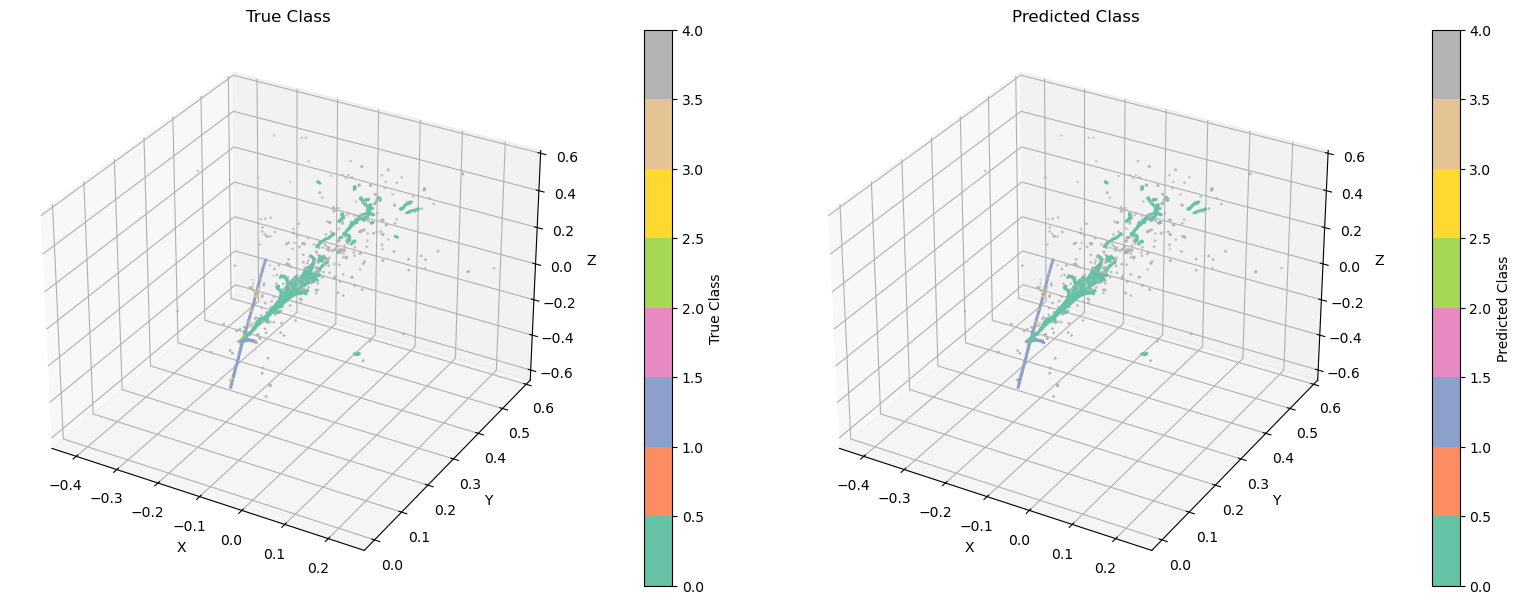

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# pick a random event from test set
dataset_test = panda.PILArNetH5Dataset(split="test", energy_threshold=0.13)
data = dataset_test[np.random.randint(0, len(dataset_test))]
for k in data.keys():
    data[k] = data[k].cuda(non_blocking=True)

# get preds
with torch.no_grad():
    logits = linear_head(model(data).feat)
    pred_class = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

true_class = data['segment_motif'].squeeze(-1).cpu().numpy()
coords = data['coord'].cpu().numpy()

fig = plt.figure(figsize=(16, 6))

def plot_classes(ax, coords, labels, title, cbar_label):
    sc = ax.scatter(
        coords[:, 0], coords[:, 1], coords[:, 2], c=labels, cmap="Set2", s=1
    )
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    cbar = fig.colorbar(sc, ax=ax, pad=0.1)
    cbar.set_label(cbar_label)

axes_titles = [("True Class", true_class, "True Class"), ("Predicted Class", pred_class, "Predicted Class")]
for i, (title, labels, cbar_label) in enumerate(axes_titles, 1):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    plot_classes(ax, coords, labels, title, cbar_label)

plt.tight_layout()
plt.show()